In [0]:
import pandas as pd
from PIL import Image
from torchvision.transforms import ToTensor, ToPILImage
import numpy as np
import random
import tarfile
import io
import os
from torch.utils.data import Dataset
import torch
from torch.autograd import Variable
import cv2
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/AutoTagImages/dataset/

/content/drive/My Drive/Colab Notebooks/AutoTagImages/dataset


In [4]:
import os
os.listdir('train_images/')

['1']

In [5]:
la = LabelEncoder()
la.fit(pd.read_csv('train.csv')['Class'])

LabelEncoder()

In [0]:
class YourDataset(Dataset):
    def __init__(self, txt_path='filelist.txt', img_dir='data', testdata=False, transform=None):
        """
        Initialize data set as a list of IDs corresponding to each item of data set

        :param img_dir: path to image files as a uncompressed tar archive
        :param txt_path: a text file containing names of all of images line by line
        :param transform: apply some transforms like cropping, rotating, etc on input image
        """

        df = pd.read_csv(txt_path)
        self.img_names = df.Image.values
        self.testdata = testdata
        if not self.testdata:
            self.target =(la.transform(df['Class']).reshape(-1,1))
        self.txt_path = txt_path
        self.img_dir = img_dir
        self.transform = transform
        self.to_tensor = ToTensor()
        self.to_pil = ToPILImage()
        self.get_image_selector = True if img_dir.__contains__('tar') else False
        self.tf = tarfile.open(self.img_dir) if self.get_image_selector else None

    def get_image_from_tar(self, name):
        """
        Gets a image by a name gathered from file list csv file

        :param name: name of targeted image
        :return: a PIL image
        """
        image = self.tf.extractfile(name)
        image = image.read()
        image = Image.open(io.BytesIO(image))
        return image

    def get_image_from_folder(self, name):
        """
        gets a image by a name gathered from file list text file

        :param name: name of targeted image
        :return: a PIL image
        """
        image = cv2.imread(os.path.join(self.img_dir, name))
        # image = cv2.resize(image, (40, 40))
        # print(self.img_dir, name)
        # image = Image.open(os.path.join(self.img_dir, name))
        myimage = Image.fromarray(image)
        return myimage

    def __len__(self):
        """
        Return the length of data set using list of IDs

        :return: number of samples in data set
        """
        return len(self.img_names)

    def __getitem__(self, index):
        """
        Generate one item of data set.

        :param index: index of item in IDs list

        :return: a sample of data as a dict
        """

        if index == (self.__len__() - 1) and self.get_image_selector:  # close tarfile opened in __init__
            self.tf.close()

        if self.get_image_selector:  # note: we prefer to extract then process!
            X = self.get_image_from_tar(self.img_names[index])
        else:
            X = self.get_image_from_folder(self.img_names[index])
            
            if not self.testdata:
                Y = self.target[index]

        if self.transform is not None:
            X = self.transform(X)

        if not self.testdata:
            sample = {'X': X,
                      'Y': Y}
        if self.testdata:
            sample = {'X': X}

        return sample

# Pytorch Model

In [0]:
import torch
from torch import nn

In [0]:
from torchvision import models

# Defining Model Architecture

In [0]:
model = models.vgg16(pretrained=True, progress=True)

In [0]:
# class Identity(nn.Module):
#     def __init__(self):
#         super(Identity, self).__init__()
        
#     def forward(self, x):
#         return x

# model.classifier = Identity()

In [0]:
# Freezing other layers of the model
for p in model.parameters():
    p.requires_grad = False

In [272]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
model.classifier = nn.Sequential()

In [0]:
# model.classifier = nn.Sequential(*list(model.classifier) + [nn.ReLU(inplace=True)] + [nn.Linear(10, 4)] + [nn.Softmax(dim=1)])
model.classifier = nn.Sequential(*list(model.classifier) + [nn.Linear(25088, 500)] + [nn.ReLU(inplace=True)] + [nn.Linear(500, 4)])

In [275]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")

Running on the GPU


In [276]:
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [277]:
from torchsummary import summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [0]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() 
# optimizer = optim.Adam(model.classifier.parameters(), lr=0.00001)
optimizer = optim.SGD(model.classifier.parameters(), lr=0.00005, momentum=0.9)#lr 0.001

# Defining Transformations

In [0]:
from torchvision import transforms

# Define train transforms
train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],  # Mean for 3 channels (RGB) for colored images
                         [0.5, 0.5, 0.5])  # Std for 3 channels
])

# Define test transforms
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],  # 3 channels (RGB) for colored images
                         [0.5, 0.5, 0.5])
])

In [0]:
from torchvision import datasets

train_data = YourDataset(txt_path='train.csv', img_dir='train_images/1/', transform=train_transforms)
test_data = YourDataset(txt_path='test.csv', img_dir='test_images/1/', testdata=True, transform=test_transforms)

In [0]:
from torch.utils.data import random_split

# calculate size of train and validation sets
train_size = int(0.8 * len(train_data))
valid_size = len(train_data) - train_size
partial_train_ds, valid_ds = random_split(train_data, [train_size, valid_size])

In [0]:
from torch.utils.data import DataLoader

# replace XX and YY with batch_size and number of workers, respectively
train_loader = DataLoader(partial_train_ds, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, num_workers=8)

In [0]:
from tqdm import tqdm_notebook

In [0]:
n_epochs = 300 # this is a hyperparameter you'll need to define
k = []
for epoch in tqdm_notebook(range(n_epochs)):
    ##################
    ### TRAIN LOOP ###
    ##################
    # set the model to train mode
    model.train()
    train_loss = 0
    total_train = 0
    total_val = 0
    correct_val = 0
    correct_train = 0
    for i in (train_loader.dataset):
        # clear the old gradients from optimized variables
        optimizer.zero_grad()
        # forward pass: feed inputs to the model to get outputs
        data, target = i['X'], i['Y']
        # target = torch.autograd.Variable(torch.tensor(target))
        data = data.view(-1, 3, 224, 224).to(device)
        target = Variable(torch.tensor(target, dtype=torch.long)).to(device)
        output = model(data)
        
        predicted = torch.argmax(output,1)
        # calculate the training batch loss
        loss = criterion(output, target)
        # backward: perform gradient descent of the loss w.r. to the model params
        loss.backward()
        # update the model parameters by performing a single optimization step
        optimizer.step()
        # accumulate the training loss
        total_train += target.size(0)
        # print(predicted, target)
        correct_train += (predicted == target).sum().item()
        
        train_loss += loss.item()
        # k+=1
        # print(k)

    #######################
    ### VALIDATION LOOP ###
    #######################
    # set the model to eval mode
    model.eval()
    valid_loss = 0
    # turn off gradients for validation
    with torch.no_grad():
        for i in (valid_loader.dataset):
            # forward pass
            data, target = i['X'], i['Y']
            data = data.view(-1, 3, 224, 224).to(device)
            target = Variable(torch.tensor(target, dtype=torch.long)).to(device)
            output = model(data)
            
            # validation batch loss
            loss = criterion(output, target) 

            # output = torch.softmax(output)
            # print(predicted, target)
            predicted = torch.argmax(output,1)
            total_val += target.size(0)
            correct_val += (predicted == target).sum().item()
            # accumulate the valid_loss
            valid_loss += loss.item()
            
    #########################
    ## PRINT EPOCH RESULTS ##
    #########################
    train_loss /= len(train_loader)
    valid_loss /= len(valid_loader)
    print(f'Epoch: {epoch+1}/{n_epochs}.. Training loss: {train_loss}.. Validation Loss: {valid_loss}')
    print(f'Training accuracy: {100 * correct_train / total_train}, Validation accuracy: {100 * correct_val / total_val}')
    

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [193]:
la.inverse_transform(train_loader.dataset[3]['Y'])

array(['Food'], dtype=object)

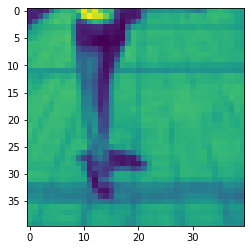

In [182]:
plt.imshow(train_loader.dataset[3]['X'][1,:])

In [205]:
k=[i['Y'] for i in train_loader.dataset]
p = [i[0] for i in k]
kk=pd.DataFrame(p, columns=['asdf'])
kk['asdf'].value_counts()/len(kk)

2    0.376724
0    0.288341
3    0.210614
1    0.124321
Name: asdf, dtype: float64

In [206]:
k=[i['Y'] for i in valid_loader.dataset]
p = [i[0] for i in k]
kk=pd.DataFrame(p, columns=['asdf'])
kk['asdf'].value_counts()/len(kk)

2    0.396825
0    0.259816
3    0.219716
1    0.123642
Name: asdf, dtype: float64